In [1]:
import os
import pandas as pd
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.neural_network import MLPClassifier
from preprocessing import preprocess_data
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import joblib

In [2]:
DATA_PATH = '../data/interim/'

# Set random seed for reproducibility
SEED = 42

# Train the models
models = {
    'Decision Tree': tree.DecisionTreeClassifier(random_state=SEED),
    'MLP': MLPClassifier(random_state=SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SVM': svm.SVC(random_state=SEED, probability=True)
}

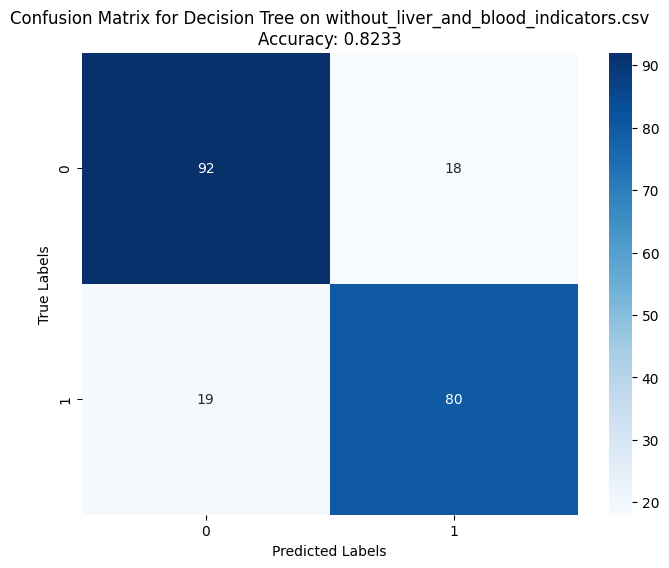

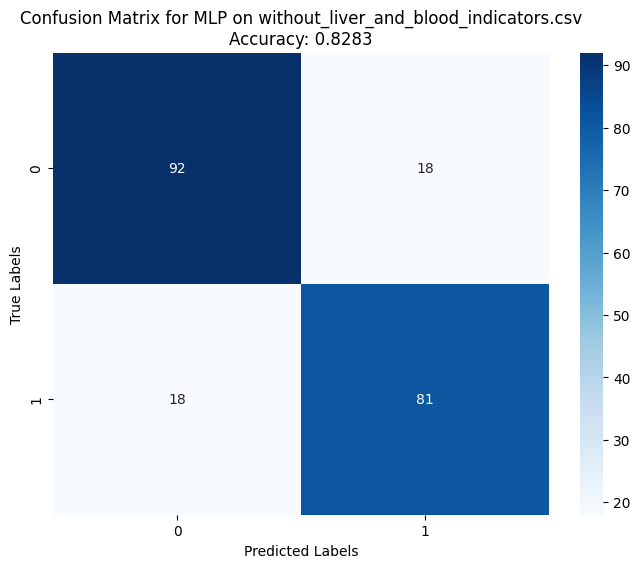

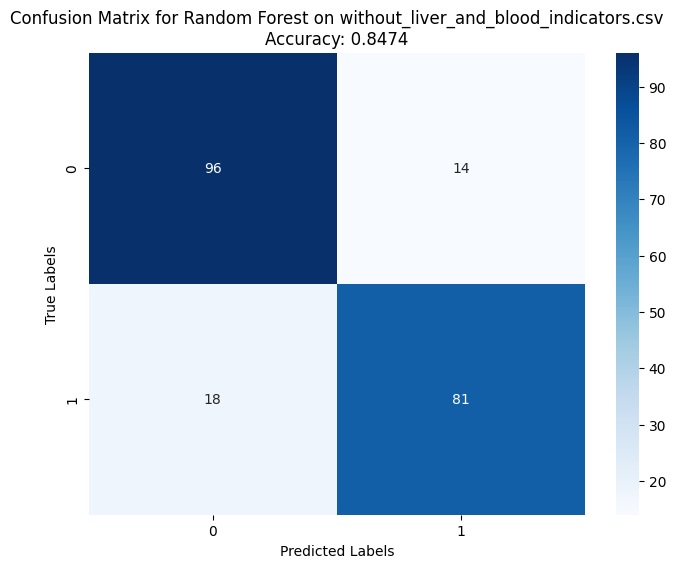

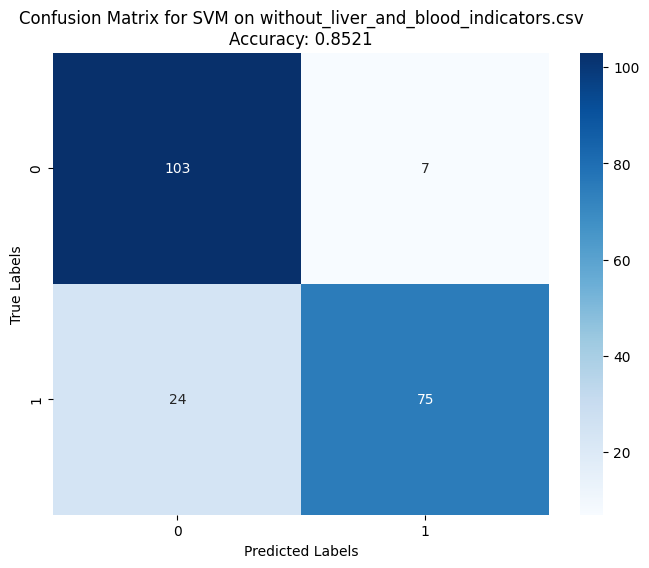

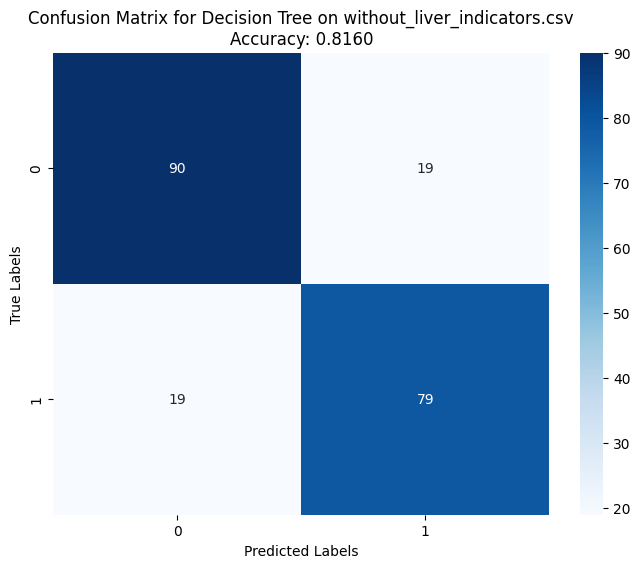

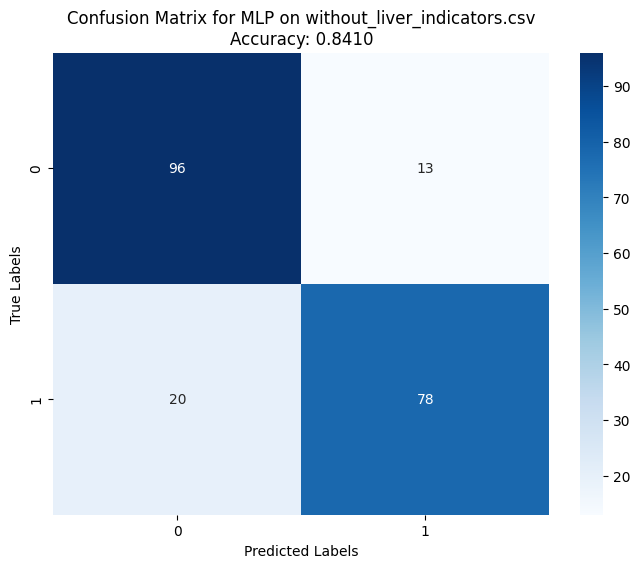

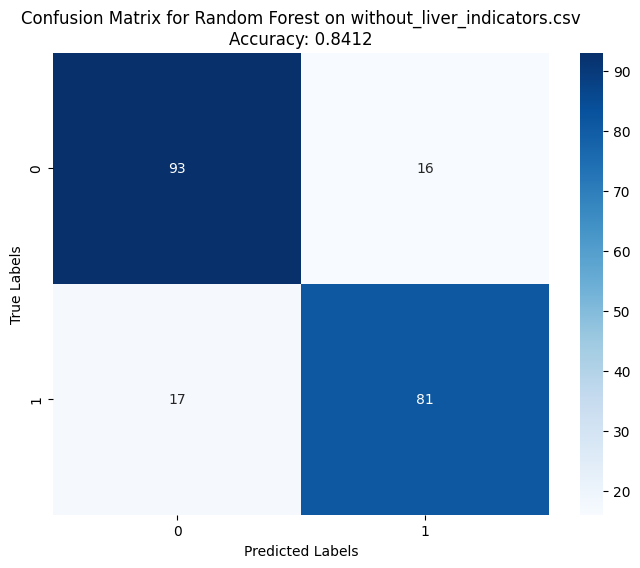

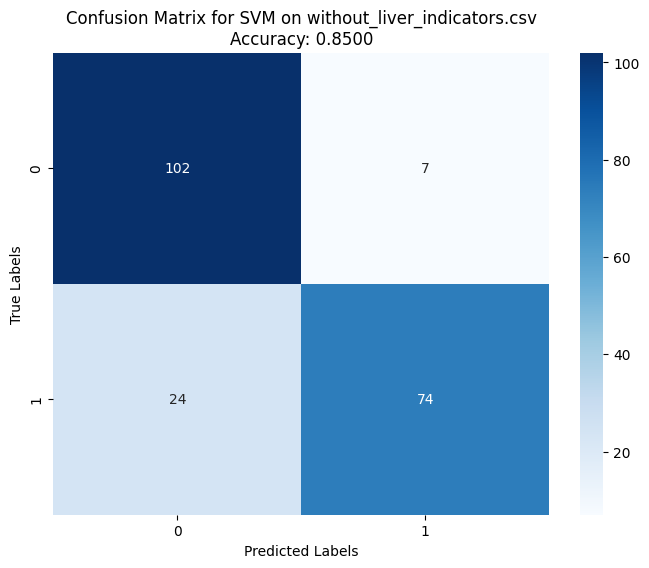

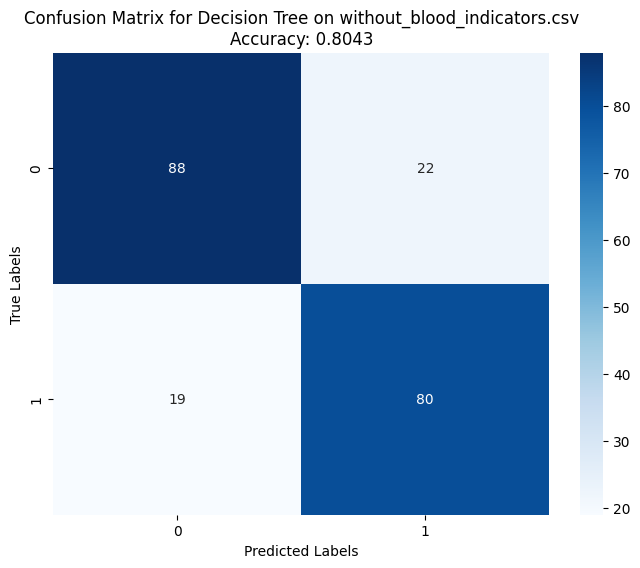

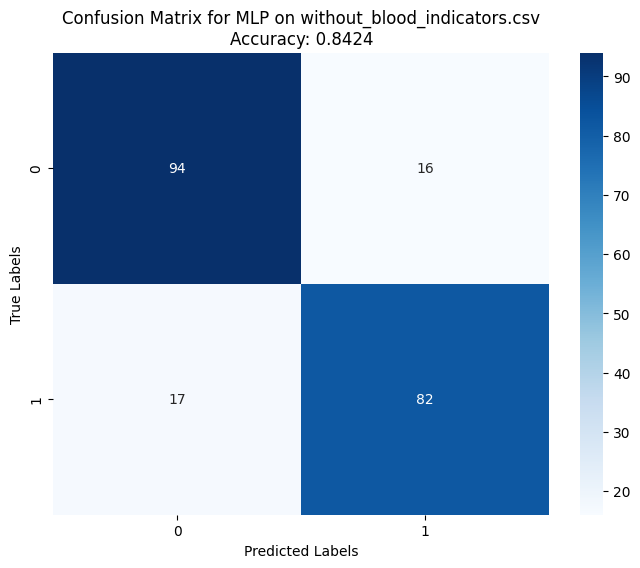

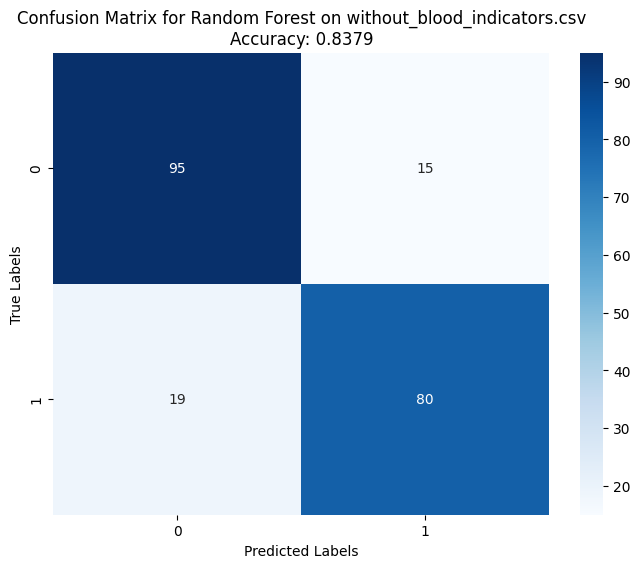

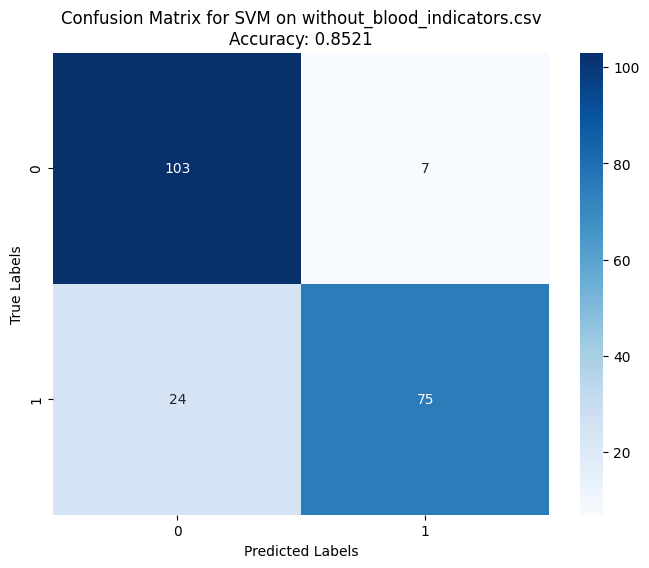

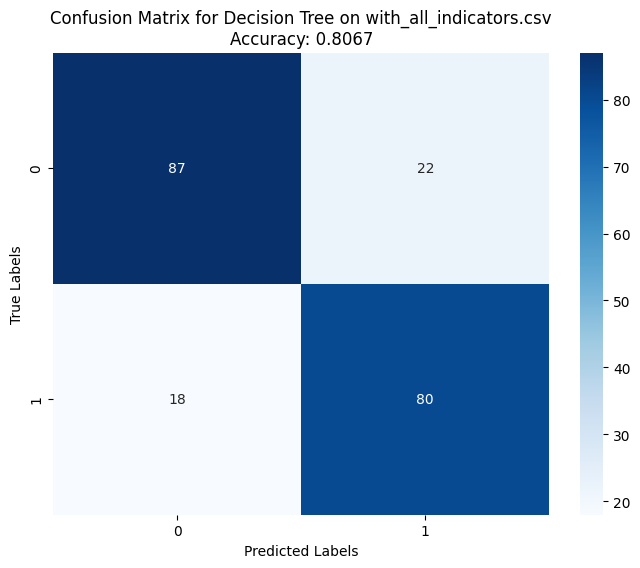

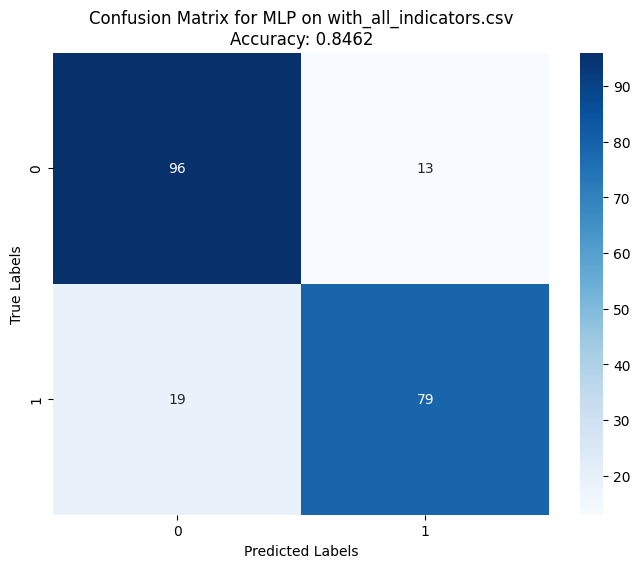

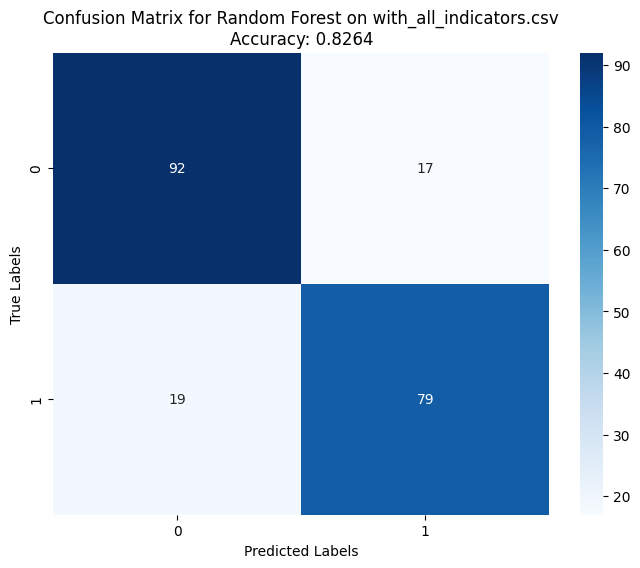

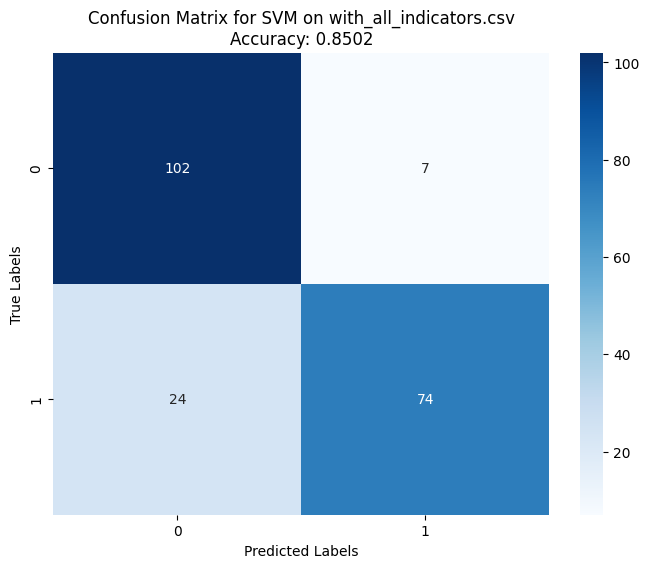

Accuracies:
Model: Decision Tree, Dataset: ../data/interim/without_liver_and_blood_indicators.csv, Accuracy: 0.8233
Model: MLP, Dataset: ../data/interim/without_liver_and_blood_indicators.csv, Accuracy: 0.8283
Model: Random Forest, Dataset: ../data/interim/without_liver_and_blood_indicators.csv, Accuracy: 0.8474
Model: SVM, Dataset: ../data/interim/without_liver_and_blood_indicators.csv, Accuracy: 0.8521
Model: Decision Tree, Dataset: ../data/interim/without_liver_indicators.csv, Accuracy: 0.8160
Model: MLP, Dataset: ../data/interim/without_liver_indicators.csv, Accuracy: 0.8410
Model: Random Forest, Dataset: ../data/interim/without_liver_indicators.csv, Accuracy: 0.8412
Model: SVM, Dataset: ../data/interim/without_liver_indicators.csv, Accuracy: 0.8500
Model: Decision Tree, Dataset: ../data/interim/without_blood_indicators.csv, Accuracy: 0.8043
Model: MLP, Dataset: ../data/interim/without_blood_indicators.csv, Accuracy: 0.8424
Model: Random Forest, Dataset: ../data/interim/without_blo

In [35]:
# Initialize result containers
accuracies = []
confusion_matrices = []

# Loop through files in the data path
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        try:
            # Load and preprocess the dataset
            df = pd.read_csv(os.path.join(DATA_PATH, file))
            df, scaler = preprocess_data(df)  # Preprocess the data
        except Exception as e:
            print(f"Error preprocessing {file}: {e}")
            continue
        
        # Identify the target column
        if 'target' in df.columns:
            target_column = 'target'
            X = df.drop(columns=['target'])
            y = df['target']
        elif 'ProgressiveDisease' in df.columns:
            target_column = 'ProgressiveDisease'
            X = df.drop(columns=[col for col in ['ProgressiveDisease', 'Progressive disease'] if col in df.columns])
            y = df['ProgressiveDisease']
        else:
            print(f"No valid target column found in {file}. Skipping.")
            continue

        # Train models and collect results
        for model_name, model in models.items():
            try:
                # Cross-validation accuracy
                scores = cross_val_score(model, X, y, cv=10)
                mean_accuracy = scores.mean()
                accuracies.append((model_name, os.path.join(DATA_PATH, file), mean_accuracy))

                # Cross-validation predictions
                y_pred = cross_val_predict(model, X, y, cv=10)

                # Confusion matrix
                cm = confusion_matrix(y, y_pred)
                confusion_matrices.append((model_name, os.path.join(DATA_PATH, file), cm))

                # Plot fancy confusion matrix with accuracy
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
                plt.title(f'Confusion Matrix for {model_name} on {file}\nAccuracy: {mean_accuracy:.4f}')
                plt.xlabel('Predicted Labels')
                plt.ylabel('True Labels')
                plt.show()

            except Exception as e:
                print(f"Error training {model_name} on {file}: {e}")
                continue

# Print results
print("Accuracies:")
for model_name, file_path, accuracy in accuracies:
    print(f"Model: {model_name}, Dataset: {file_path}, Accuracy: {accuracy:.4f}")

        Sex  Age at diagnosis  Final diagnosis  TOBACCO  Comorbidities  \
30   Female              73.0                1        0              1   
173    Male              76.0                1        2              1   
140  Female              74.0                1        0              1   
75     Male              58.0                5        2              0   
60     Male              63.0                6        2              0   

    Radiological Pattern  Biopsy Pathology pattern  Diagnosis after Biopsy  \
30                   UIP     0.0                 0                    -9.0   
173                  UIP     0.0                 0                    -9.0   
140         Probable UIP     1.0      Probable UIP                     1.0   
75     Indeterminate UIP     NaN                 0                    -9.0   
60               Non UIP     0.0                 0                    -9.0   

     Antifibrotic Drug  ...  RadioWorsening2y  1st degree relative  \
30              

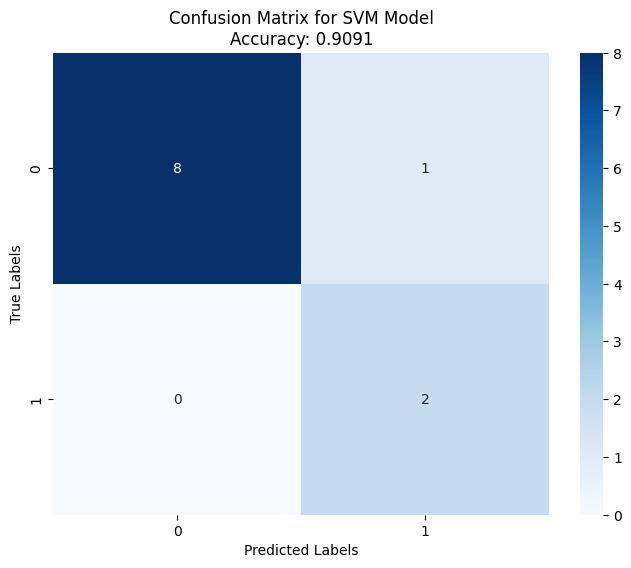

In [ ]:
# Path to the best dataset
path_to_best_csv = os.path.join(DATA_PATH, 'without_liver_and_blood_indicators.csv')

# Read dataset
df = pd.read_csv(path_to_best_csv)

# Preprocess the data (but keep a copy of the original dataframe)
df_original = df.copy()  # Store the original data before preprocessing
df, scaler = preprocess_data(df)  # preprocess_data should be defined elsewhere in your code

# Save the scaler
joblib.dump(scaler, f'scaler_{os.path.basename(path_to_best_csv)}.pkl')  

# Identify the target column (assuming 'target' is the column you're predicting)
if 'target' in df.columns:
    target_column = 'target'
    X = df.drop(columns=['target'])
    y = df['target']
else:
    print("No valid target column found. Skipping.")
    exit()

# Train-test split (95-5 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=SEED)

# Initialize and train the SVM model
model = SVC(random_state=SEED, probability=True)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, f'svm_model_{os.path.basename(path_to_best_csv)}.pkl')

# Predict probabilities on the test set
y_proba = model.predict_proba(X_test)

# For binary classification, use the probabilities of the positive class (class 1)
df_test_with_predictions = df_original.iloc[X_test.index].copy()  # Keep the original rows from the unscaled data
df_test_with_predictions['actual'] = y_test
df_test_with_predictions['predicted_probability'] = y_proba[:, 1]

# Save the results to a new CSV file
output_file = f'svm_model_with_predictions_and_probabilities_{os.path.basename(path_to_best_csv)}.csv'
df_test_with_predictions.to_csv(output_file, index=False)

# Confusion matrix (on the test set)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix for SVM Model\nAccuracy: {model.score(X_test, y_test):.4f}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

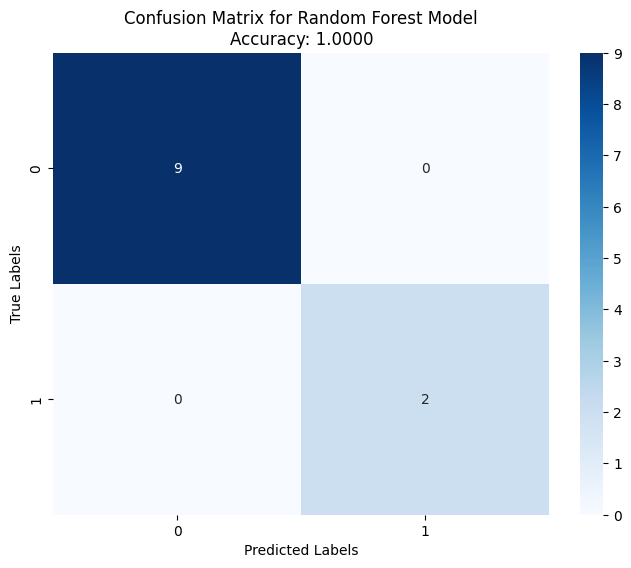

In [3]:
# Path to the best dataset
path_to_best_csv = os.path.join(DATA_PATH, 'without_liver_and_blood_indicators.csv')

# Read dataset
df = pd.read_csv(path_to_best_csv)

# Preprocess the data (but keep a copy of the original dataframe)
df_original = df.copy()  # Store the original data before preprocessing
df, scaler = preprocess_data(df)  # preprocess_data should be defined elsewhere in your code

# Identify the target column (assuming 'target' is the column you're predicting)
if 'target' in df.columns:
    target_column = 'target'
    X = df.drop(columns=['target'])
    y = df['target']
else:
    print("No valid target column found. Skipping.")
    exit()

# Train-test split (95-5 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=SEED)

# Initialize and train the RandomForest model
model = RandomForestClassifier(random_state=SEED)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, f'random_forest_model_{os.path.basename(path_to_best_csv)}.pkl')

# Predict probabilities on the test set
y_proba = model.predict_proba(X_test)

# For binary classification, use the probabilities of the positive class (class 1)
df_test_with_predictions = df_original.iloc[X_test.index].copy()  # Keep the original rows from the unscaled data
df_test_with_predictions['actual'] = y_test
df_test_with_predictions['predicted_probability'] = y_proba[:, 1]

# Save the results to a new CSV file
output_file = f'random_forest_model_with_predictions_and_probabilities_{os.path.basename(path_to_best_csv)}.csv'
df_test_with_predictions.to_csv(output_file, index=False)

# Confusion matrix (on the test set)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix for Random Forest Model\nAccuracy: {model.score(X_test, y_test):.4f}')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
